In [41]:
# 1 - SETUP Y DEPENDENCIAS
# ------------------------------------------------------------
import math
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from dataclasses import dataclass
from typing import Tuple, List, Dict, Optional
from fractions import Fraction
from math import gcd

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Reproducibilidad y dispositivo
SEED = 1234
np.random.seed(SEED)
torch.manual_seed(SEED)
device = None
if torch.cuda.is_available():
    device = torch.device("cuda")
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device = torch.device("mps")
    
else:
    device = torch.device("cpu")

# Dtype por dispositivo (MPS -> float32)
TORCH_DTYPE = torch.float32 if device.type == "mps" else torch.float64
torch.set_default_dtype(TORCH_DTYPE)

# Parámetros físicos adimensionales
@dataclass
class Params:
    zeta: float = 1 # ζ
    kappa: float = 12.30
    A1: float = 1.0
    A2: float = 0.6
    omega: float = 1.2   # ω1
    omega2: float = 1.3 # ω2

P = Params()

# Utilidades ω actuales y periodo común (si existe)
def get_omegas() -> Tuple[float, float]:
    return float(P.omega), float(P.omega2)

def _lcm(a: int, b: int) -> int:
    return a * b // gcd(a, b)

def _lcm_many(ints: List[int]) -> int:
    L = 1
    for q in ints:
        L = _lcm(L, q)
    return L

def fundamental_freq(omegas: List[float], max_den: int = 2000, tol: float = 1e-10):
    if not omegas or omegas[0] <= 0:
        return None, None, None
    w0 = omegas[0]
    pq = []
    for w in omegas:
        r = Fraction(w / w0).limit_denominator(max_den)
        if abs(float(r) - (w / w0)) > tol:
            return None, None, None
        pq.append((r.numerator, r.denominator))
    L = _lcm_many([q for (_, q) in pq])
    omega_base = w0 / L
    k_list = [(p * L) // q for (p, q) in pq]
    for w, k in zip(omegas, k_list):
        if abs(w - k * omega_base) > 1e-9:
            return None, None, None
    T_periodic = 2.0 * math.pi / omega_base
    return omega_base, k_list, T_periodic

def get_T_periodic() -> Optional[float]:
    w1, w2 = get_omegas()
    _, _, T = fundamental_freq([w1, w2])
    return T

# Rango temporal
N_PERIODS = 12
T_PERIODIC = get_T_periodic()
if T_PERIODIC is not None:
    t_ini, t_fin = 0.0, N_PERIODS * T_PERIODIC
else:
    w1, w2 = get_omegas()
    T_ref = 2.0 * math.pi / min(w1, w2)
    t_ini, t_fin = 0.0, N_PERIODS * T_ref

# IC (se resetean en Celda 2 con la analítica correcta)
x10, v10 = 0.0, 1.0
x20, v20 = 1.0, 0.0

# Muestreo y features
N_COL = 4000
N_IC  = 64
USE_PERIODICITY = True
N_PB  = 256

USE_FOURIER = True
N_HARMONICS = 6

# Entrenamiento
LR = 1e-3
EPOCHS = 4000
PRINT_EACH = 200
USE_LBFGS = True

# Pesos
W_PHYS = 4.0
W_IC   = 5.0
W_PB   = 2.0

# Resolución
N_EVAL = 1200


In [42]:
# 2 - SOLUCIÓN ANALÍTICA (DOS FRECUENCIAS DISTINTAS POR COMPONENTE) + IC CONSISTENTES
# -----------------------------------------------------------------------------------
import numpy as np
from typing import Tuple, List

def analytic_amplitudes(zeta: float, kappa: float, G: np.ndarray, omega: float) -> np.ndarray:
    """
    Resuelve (K - ω^2 I + i 2ζ ω I) X = G  para un ω dado y un vector complejo G de tamaño 2.
    """
    K = np.array([[1.0 + kappa, -kappa],
                  [-kappa, 1.0 + kappa]], dtype=np.complex128)
    I = np.eye(2, dtype=np.complex128)
    D = K - (omega**2) * I + 1j * 2.0 * zeta * omega * I
    X = np.linalg.solve(D, G)
    return X  # complejo

def analytic_solution_twofreq(t: np.ndarray, zeta: float, kappa: float, A1: float, A2: float, omega1: float, omega2: float):
    """
    g(t) = [A1 cos(ω1 t), A2 sin(ω2 t)].
    Por superposición: x(t) = x^(1)(t) + x^(2)(t),
      con (ω1, G1=[A1, 0]) y (ω2, G2=[0, -iA2]).
    """
    # Subproblema 1: cos(ω1 t) en comp. 1
    G1 = np.array([A1, 0.0], dtype=np.complex128)  # cos -> amplitud real A1 en comp1
    X1 = analytic_amplitudes(zeta, kappa, G1, omega1)  # complejo
    X1r, X1i = X1.real, X1.imag
    cos1, sin1 = np.cos(omega1 * t), np.sin(omega1 * t)

    # Subproblema 2: sin(ω2 t) en comp. 2
    G2 = np.array([0.0, -1j * A2], dtype=np.complex128)  # sin -> -i A2 en comp2
    X2 = analytic_amplitudes(zeta, kappa, G2, omega2)
    X2r, X2i = X2.real, X2.imag
    cos2, sin2 = np.cos(omega2 * t), np.sin(omega2 * t)

    x1 = X1r[0]*cos1 - X1i[0]*sin1 + X2r[0]*cos2 - X2i[0]*sin2
    x2 = X1r[1]*cos1 - X1i[1]*sin1 + X2r[1]*cos2 - X2i[1]*sin2
    return x1, x2, (X1, X2)

# --- Construcción de analítica e IC coherentes ---
w1, w2 = get_omegas()
t_eval = np.linspace(t_ini, t_fin, N_EVAL)
x1_real, x2_real, (X1, X2) = analytic_solution_twofreq(t_eval, P.zeta, P.kappa, P.A1, P.A2, w1, w2)

# IC: x(0) = Re{X1 + X2}, v(0) = -ω1 Im{X1} - ω2 Im{X2}
#x10 = float((X1.real + X2.real)[0]); x20 = float((X1.real + X2.real)[1])
#v10 = float(-(w1*X1.imag[0] + w2*X2.imag[0]))
#v20 = float(-(w1*X1.imag[1] + w2*X2.imag[1]))

x10 = 1.0; x20 = 0.0
v10 = 0.
v20 = 1.

print(f"[analítica] ω usadas = (ω1={w1}, ω2={w2})")
print(f"IC: x1(0)={x10:.6f}, v1(0)={v10:.6f} | x2(0)={x20:.6f}, v2(0)={v20:.6f}")


[analítica] ω usadas = (ω1=1.2, ω2=1.3)
IC: x1(0)=1.000000, v1(0)=0.000000 | x2(0)=0.000000, v2(0)=1.000000


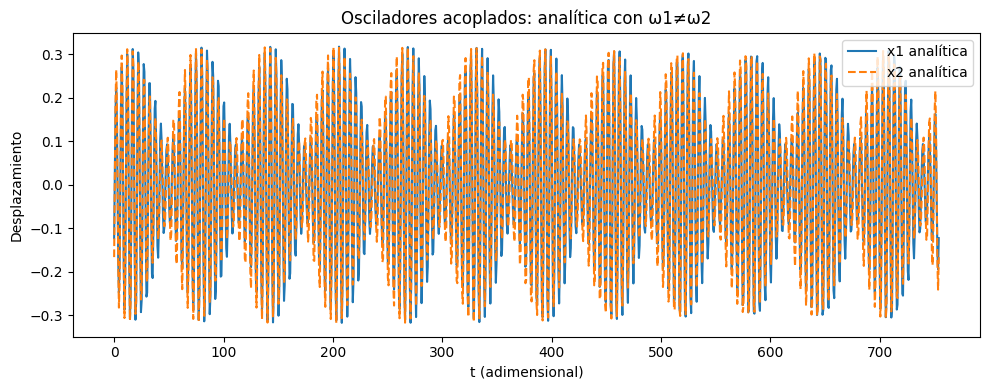

In [43]:
# 3 - GRÁFICA: ANALÍTICA (ω1 en cos comp1, ω2 en sin comp2)
plt.figure(figsize=(10,4))
plt.plot(t_eval, x1_real, label="x1 analítica")
plt.plot(t_eval, x2_real, label="x2 analítica", linestyle="--")
plt.xlabel("t (adimensional)")
plt.ylabel("Desplazamiento")
plt.title("Osciladores acoplados: analítica con ω1≠ω2")
plt.legend()
plt.tight_layout()
plt.show()


In [44]:
# 4 - PINN: ENCODER FOURIER (dedupe) + RESIDUOS CON DOS FRECUENCIAS (por componente)
from typing import List, Tuple, Optional

class FrequencyBankFourierFeatures(nn.Module):
    def __init__(self, omegas: List[float], n_harmonics: int, dedupe_tol: float = 1e-10, include_raw_t: bool = False):
        super().__init__()
        self.include_raw_t = include_raw_t
        freqs: List[float] = []
        for w in omegas:
            for n in range(1, n_harmonics + 1):
                f = float(n) * float(w)
                if not any(abs(f - f0) <= dedupe_tol for f0 in freqs):
                    freqs.append(f)
        freqs.sort()
        self.register_buffer("freqs_tensor", torch.tensor(freqs, dtype=TORCH_DTYPE))
        self._out_dim = (1 if include_raw_t else 0) + 2 * len(freqs)

    def forward(self, t: torch.Tensor) -> torch.Tensor:
        feats = []
        if self.include_raw_t:
            feats.append(t)
        for f in self.freqs_tensor:
            feats.append(torch.sin(f * t))
            feats.append(torch.cos(f * t))
        return torch.cat(feats, dim=1)

    def out_features(self) -> int:
        return self._out_dim

class MLP(nn.Module):
    def __init__(self, n_in: int, n_out: int = 2, width: int = 128, depth: int = 5, act=nn.Tanh):
        super().__init__()
        layers = [nn.Linear(n_in, width), act()]
        for _ in range(depth - 1):
            layers += [nn.Linear(width, width), act()]
        layers += [nn.Linear(width, n_out)]
        self.net = nn.Sequential(*layers)
        self.apply(self._init)

    @staticmethod
    def _init(m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            nn.init.zeros_(m.bias)

    def forward(self, x):
        return self.net(x)

def build_ff(n_harmonics: int, use_fourier: bool):
    if not use_fourier:
        return None
    w1, w2 = get_omegas()
    return FrequencyBankFourierFeatures([w1, w2], n_harmonics, include_raw_t=False).to(device)

def build_model(n_in: int, width: int, depth: int, act=nn.Tanh):
    return MLP(n_in=n_in, n_out=2, width=width, depth=depth, act=act).to(device)

def encode_time(ff, t: torch.Tensor) -> torch.Tensor:
    return ff(t) if ff is not None else t

# Derivadas
def ddt(y: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
    return torch.autograd.grad(y, t, grad_outputs=torch.ones_like(y), create_graph=True, retain_graph=True)[0]

def ddtt(y: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
    dy = ddt(y, t)
    return torch.autograd.grad(dy, t, grad_outputs=torch.ones_like(dy), create_graph=True, retain_graph=True)[0]

# Fuerza g(t) correcta (no suma): g1=A1 cos(ω1 t), g2=A2 sin(ω2 t)
def g_batch(t: torch.Tensor, A1: float, A2: float, omega1: float, omega2: float) -> torch.Tensor:
    g1 = A1 * torch.cos(omega1 * t)
    g2 = A2 * torch.sin(omega2 * t)
    return torch.cat([g1, g2], dim=1)

def sample_collocation(n: int) -> torch.Tensor:
    return (torch.rand(n, 1, device=device, dtype=TORCH_DTYPE) * (t_fin - t_ini) + t_ini).requires_grad_(True)

def sample_ic(n: int) -> torch.Tensor:
    return torch.zeros(n, 1, device=device, dtype=TORCH_DTYPE, requires_grad=True)

def sample_periodic(n: int, T_periodic: Optional[float]):
    tA = (torch.rand(n, 1, device=device, dtype=TORCH_DTYPE) * (t_fin - t_ini - T_periodic) + t_ini).requires_grad_(True)
    tB = (tA + T_periodic).requires_grad_(True)
    return tA, tB

# Residuos físicos con ω1, ω2 explícitos
def physics_residuals(t: torch.Tensor, model: nn.Module, ff, zeta: float, kappa: float, A1: float, A2: float, omega1: float, omega2: float):
    xin = encode_time(ff, t)
    x = model(xin)                  # (N,2)
    x1, x2 = x[:, 0:1], x[:, 1:2]
    x1_t = ddt(x1, t); x2_t = ddt(x2, t)
    x1_tt = ddtt(x1, t); x2_tt = ddtt(x2, t)

    g = g_batch(t, A1, A2, omega1, omega2)
    g1, g2 = g[:, 0:1], g[:, 1:2]

    r1 = x1_tt + 2*zeta*x1_t + (1+kappa)*x1 - kappa*x2 - g1
    r2 = x2_tt + 2*zeta*x2_t + (1+kappa)*x2 - kappa*x1 - g2
    return r1, r2, x1, x2, x1_t, x2_t


In [45]:
# 5 - PÉRDIDAS Y ENTRENAMIENTO (Adam + LBFGS estable) con ω1, ω2 explícitos
from copy import deepcopy
import time
from tqdm.auto import tqdm

def build_batch(n_col: int, n_ic: int, n_pb: int, use_per_eff: bool, T_periodic: Optional[float]):
    t_col = sample_collocation(n_col)
    t0 = sample_ic(n_ic)
    tA = tB = None
    if use_per_eff:
        tA, tB = sample_periodic(n_pb, T_periodic)
    return {"t_col": t_col, "t0": t0, "tA": tA, "tB": tB, "use_per": use_per_eff}

def loss_from_batch(model: nn.Module, ff, batch: dict, w_phys: float, w_ic: float, w_pb: float,
                    zeta: float, kappa: float, A1: float, A2: float, omega1: float, omega2: float):
    t_col, t0, tA, tB, use_per_eff = batch["t_col"], batch["t0"], batch["tA"], batch["tB"], batch["use_per"]

    r1, r2, _, _, _, _ = physics_residuals(t_col, model, ff, zeta, kappa, A1, A2, omega1, omega2)
    L_phys = (r1**2).mean() + (r2**2).mean()

    _, _, x1_0_hat, x2_0_hat, v1_0_hat, v2_0_hat = physics_residuals(t0, model, ff, zeta, kappa, A1, A2, omega1, omega2)
    L_ic = ((x1_0_hat - x10)**2).mean() + ((x2_0_hat - x20)**2).mean() \
         + ((v1_0_hat - v10)**2).mean() + ((v2_0_hat - v20)**2).mean()

    L_per = torch.tensor(0.0, device=device)
    if use_per_eff and (tA is not None):
        xA = model(encode_time(ff, tA)); dA = ddt(xA, tA)
        xB = model(encode_time(ff, tB)); dB = ddt(xB, tB)
        L_per = ((xA - xB)**2).mean() + ((dA - dB)**2).mean()

    L = w_phys*L_phys + w_ic*L_ic + (w_pb*L_per if use_per_eff else 0.0)
    logs = {"phys": L_phys.item(), "ic": L_ic.item(), "per": (L_per.item() if use_per_eff else 0.0)}
    return L, logs

def train_run(width=128, depth=5, n_harmonics=6, use_fourier=True, use_periodicity=True,
              lr=1e-3, epochs=2000, print_each=200,
              n_col=4000, n_ic=64, n_pb=256, w_phys=1.0, w_ic=5.0, w_pb=1.0, use_lbfgs=True,
              seed=1234, save_checkpoints=False,
              show_epoch_bar=True, epoch_bar_desc=None,
              warmup_epochs=300):
    np.random.seed(seed); torch.manual_seed(seed)

    ff = build_ff(n_harmonics, use_fourier)
    n_in = ff.out_features() if ff is not None else 1
    model = build_model(n_in, width=width, depth=depth)

    T_periodic = get_T_periodic()
    w1, w2 = get_omegas()

    optimizer = optim.Adam(model.parameters(), lr=lr)
    history = {"total": [], "phys": [], "ic": [], "per": []}
    checkpoints = []
    t_grid = torch.linspace(t_ini, t_fin, N_EVAL, device=device, dtype=TORCH_DTYPE).view(-1,1)

    epoch_iter = range(1, epochs+1)
    if show_epoch_bar:
        epoch_iter = tqdm(epoch_iter, total=epochs, leave=True, desc=epoch_bar_desc or "Entrenamiento")

    for epoch in epoch_iter:
        use_per_eff = bool(use_periodicity and (T_periodic is not None) and (epoch > warmup_epochs))
        batch = build_batch(n_col, n_ic, n_pb, use_per_eff, T_periodic)

        optimizer.zero_grad()
        L, logs = loss_from_batch(model, ff, batch, w_phys, w_ic, w_pb, P.zeta, P.kappa, P.A1, P.A2, w1, w2)
        L.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        history["total"].append(L.item())
        history["phys"].append(logs["phys"])
        history["ic"].append(logs["ic"])
        history["per"].append(logs["per"])
        if show_epoch_bar:
            epoch_iter.set_postfix(loss=float(L.item()), phys=float(logs["phys"]), ic=float(logs["ic"]))

        if save_checkpoints and (epoch % print_each == 0 or epoch == 1):
            with torch.no_grad():
                x_hat = model(encode_time(ff, t_grid)).detach().cpu().numpy()
            checkpoints.append((epoch, x_hat[:, 0].copy(), x_hat[:, 1].copy()))

    # LBFGS con lote fijo
    if use_lbfgs:
        use_per_eff_final = bool(use_periodicity and (T_periodic is not None))
        frozen_batch = build_batch(n_col, n_ic, n_pb, use_per_eff_final, T_periodic)

        def closure():
            optimizer_lbfgs.zero_grad()
            Lc, _ = loss_from_batch(model, ff, frozen_batch, w_phys, w_ic, w_pb, P.zeta, P.kappa, P.A1, P.A2, w1, w2)
            Lc.backward()
            return Lc

        optimizer_lbfgs = optim.LBFGS(model.parameters(), max_iter=500,
                                      tolerance_grad=1e-9, tolerance_change=1e-12,
                                      line_search_fn="strong_wolfe")
        L_final = optimizer_lbfgs.step(closure).item()
        history["total"].append(L_final)
        if save_checkpoints:
            with torch.no_grad():
                x_hat = model(encode_time(ff, t_grid)).detach().cpu().numpy()
            checkpoints.append((epochs+999, x_hat[:, 0].copy(), x_hat[:, 1].copy()))

    # Métrica MSE vs analítica correcta
    with torch.no_grad():
        x_hat = model(encode_time(ff, t_grid)).detach().cpu().numpy()
    t_eval_local = t_grid.detach().cpu().numpy().squeeze()
    x1r, x2r, _ = analytic_solution_twofreq(t_eval_local, P.zeta, P.kappa, P.A1, P.A2, w1, w2)
    val_mse = float(np.mean((x_hat[:, 0]-x1r)**2 + (x_hat[:, 1]-x2r)**2))

    state = deepcopy(model.state_dict())
    meta = {"width": width, "depth": depth, "n_harmonics": n_harmonics, "use_fourier": use_fourier,
            "use_periodicity": bool(use_periodicity and (T_periodic is not None)),
            "lr": lr, "epochs": epochs, "seed": seed,
            "n_col": n_col, "n_ic": n_ic, "n_pb": n_pb, "use_lbfgs": use_lbfgs,
            "warmup_epochs": warmup_epochs,
            "omegas_used": (w1, w2), "T_periodic_used": T_periodic}

    return model, ff, state, history, checkpoints, val_mse, meta


In [46]:
# 6 - GRID LIGERO (coherente con ω1, ω2 explícitos)
import pandas as pd
from tqdm.auto import tqdm

architectures = [
    {"name":"MLP_w64_d3",   "width":64,  "depth":3},
]

def build_hp_grid():
    letters = [
        ("A", {"lr":2e-3, "epochs":1500, "n_harmonics":2}),
        ("B", {"lr":1e-3, "epochs":2000, "n_harmonics":3}),
        ("C", {"lr":7e-4, "epochs":2500, "n_harmonics":4}),
        ("D", {"lr":5e-4, "epochs":3000, "n_harmonics":5}),
        ("E", {"lr":3e-4, "epochs":4000, "n_harmonics":6}),
    ]
    configs = [
        (1, {"use_periodicity":False, "use_lbfgs":False}),
        (2, {"use_periodicity":False, "use_lbfgs":True}),
        (3, {"use_periodicity":True,  "use_lbfgs":True}),
        (4, {"use_periodicity":True,  "use_lbfgs":False}),
    ]
    grid = []
    for letter, base in letters:
        for idx, flags in configs:
            name = f"HP_{letter}_{idx}"
            epochs = base["epochs"]
            print_each = max(200, epochs//5)
            grid.append({
                "name": name,
                "lr": base["lr"],
                "epochs": epochs,
                "n_harmonics": base["n_harmonics"],
                "use_periodicity": flags["use_periodicity"],
                "use_lbfgs": flags["use_lbfgs"],
                "print_each": print_each,
            })
    return grid

hp_grid = build_hp_grid()

top_pairs = [
    ("MLP_w64_d3",  "HP_C_2"),
]

def get_arch(name: str):
    m = [a for a in architectures if a["name"] == name]
    assert len(m)==1, f"Arquitectura '{name}' no encontrada"
    return m[0]

def get_hp(name: str):
    m = [h for h in hp_grid if h["name"] == name]
    assert len(m)==1, f"HP '{name}' no encontrado"
    return m[0]

all_results = []
runs = {}

print(f">>> Entrenando {len(top_pairs)} combinaciones (ω1, ω2) = {get_omegas()} ...")
with tqdm(total=len(top_pairs), desc="runs", position=0) as pbar:
    for arch_name, hp_name in top_pairs:
        arch = get_arch(arch_name)
        hp   = get_hp(hp_name)
        epoch_desc = f"{arch['name']} | {hp['name']}"

        model_g, ff_g, state_g, hist_g, cpts_g, mse_g, meta_g = train_run(
            width=arch["width"], depth=arch["depth"],
            n_harmonics=hp["n_harmonics"], use_fourier=True, use_periodicity=hp["use_periodicity"],
            lr=hp["lr"], epochs=hp["epochs"], print_each=hp["print_each"],
            n_col=N_COL, n_ic=N_IC, n_pb=N_PB,
            w_phys=W_PHYS, w_ic=W_IC, w_pb=W_PB,
            use_lbfgs=hp["use_lbfgs"], seed=SEED, save_checkpoints=False,
            show_epoch_bar=True, epoch_bar_desc=epoch_desc, warmup_epochs=300
        )

        all_results.append({
            "arch": arch["name"],
            "hp": hp["name"],
            "val_mse": mse_g,
            "final_loss": hist_g["total"][-1],
            "epochs": hp["epochs"],
            "lr": hp["lr"],
            "n_harmonics": hp["n_harmonics"],
            "use_periodicity": meta_g["use_periodicity"],
            "use_lbfgs": hp["use_lbfgs"],
            "width": arch["width"],
            "depth": arch["depth"],
            "elapsed_sec": meta_g.get("elapsed_sec", None)
        })
        key = f"{arch['name']}__{hp['name']}"
        runs[key] = {"state": state_g, "meta": meta_g, "history": hist_g, "arch": arch, "hp": hp}
        pbar.update(1)

df_results = pd.DataFrame(all_results).sort_values(by="val_mse", ascending=True).reset_index(drop=True)
print("\nResultados por MSE:")
print(df_results)


>>> Entrenando 1 combinaciones (ω1, ω2) = (1.2, 1.3) ...


runs:   0%|          | 0/1 [00:00<?, ?it/s]

MLP_w64_d3 | HP_C_2:   0%|          | 0/2500 [00:00<?, ?it/s]


Resultados por MSE:
         arch      hp   val_mse  final_loss  epochs      lr  n_harmonics  \
0  MLP_w64_d3  HP_C_2  0.037218    1.771331    2500  0.0007            4   

   use_periodicity  use_lbfgs  width  depth elapsed_sec  
0            False       True     64      3        None  


In [47]:
# 7 - SANITY CHECK: analítica (ω1, ω2) vs (ω1, ω1) deben diferir
w1, w2 = get_omegas()
t_chk = np.linspace(0.0, 6*2*np.pi/min(w1,w2), 2000)
x1_12, x2_12, _ = analytic_solution_twofreq(t_chk, P.zeta, P.kappa, P.A1, P.A2, w1, w2)
x1_11, x2_11, _ = analytic_solution_twofreq(t_chk, P.zeta, P.kappa, P.A1, P.A2, w1, w1)

l2_x1 = np.sqrt(np.mean((x1_12 - x1_11)**2))
l2_x2 = np.sqrt(np.mean((x2_12 - x2_11)**2))
print(f"[sanity] ||x1(ω1,ω2)-x1(ω1,ω1)||_2 = {l2_x1:.3e}")
print(f"[sanity] ||x2(ω1,ω2)-x2(ω1,ω1)||_2 = {l2_x2:.3e}")


[sanity] ||x1(ω1,ω2)-x1(ω1,ω1)||_2 = 1.152e-01
[sanity] ||x2(ω1,ω2)-x2(ω1,ω1)||_2 = 1.138e-01


In [48]:
# 8 - SELECCIÓN MEJOR CONFIG + REENTRENAMIENTO CON CHECKPOINTS
assert len(df_results) > 0, "df_results vacío; ejecuta Celda 6."

best_row = df_results.iloc[0]
best_arch_name = best_row["arch"]
best_hp_name   = best_row["hp"]
print("Mejor configuración encontrada:")
print(best_row)

arch_best = get_arch(best_arch_name)
hp_best   = get_hp(best_hp_name)

model_best, ff_best, state_best, history_best, checkpoints_best, mse_best, meta_best = train_run(
    width=arch_best["width"], depth=arch_best["depth"],
    n_harmonics=hp_best["n_harmonics"], use_fourier=True, use_periodicity=hp_best["use_periodicity"],
    lr=hp_best["lr"], epochs=hp_best["epochs"], print_each=hp_best["print_each"],
    n_col=N_COL, n_ic=N_IC, n_pb=N_PB, w_phys=W_PHYS, w_ic=W_IC, w_pb=W_PB,
    use_lbfgs=hp_best["use_lbfgs"], seed=SEED, save_checkpoints=True,
    warmup_epochs=300
)
print("MSE de la mejor config (reentrenada):", mse_best)

best_bundle = {
    "arch": arch_best, "hp": hp_best,
    "state": state_best, "history": history_best,
    "checkpoints": checkpoints_best, "meta": meta_best
}


Mejor configuración encontrada:
arch               MLP_w64_d3
hp                     HP_C_2
val_mse              0.037218
final_loss           1.771331
epochs                   2500
lr                     0.0007
n_harmonics                 4
use_periodicity         False
use_lbfgs                True
width                      64
depth                       3
elapsed_sec              None
Name: 0, dtype: object


Entrenamiento:   0%|          | 0/2500 [00:00<?, ?it/s]

MSE de la mejor config (reentrenada): 0.03721776776870388


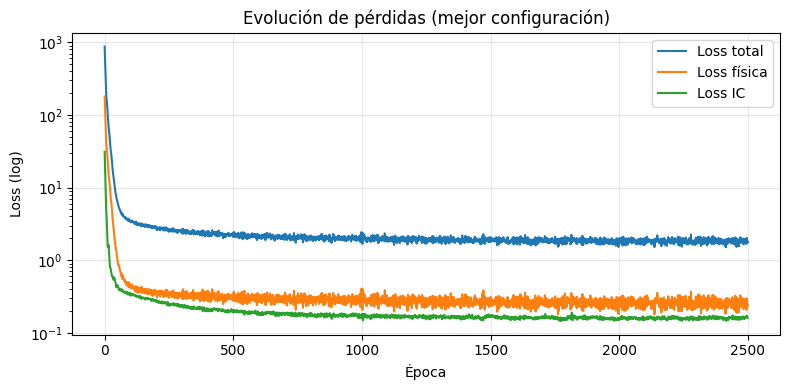

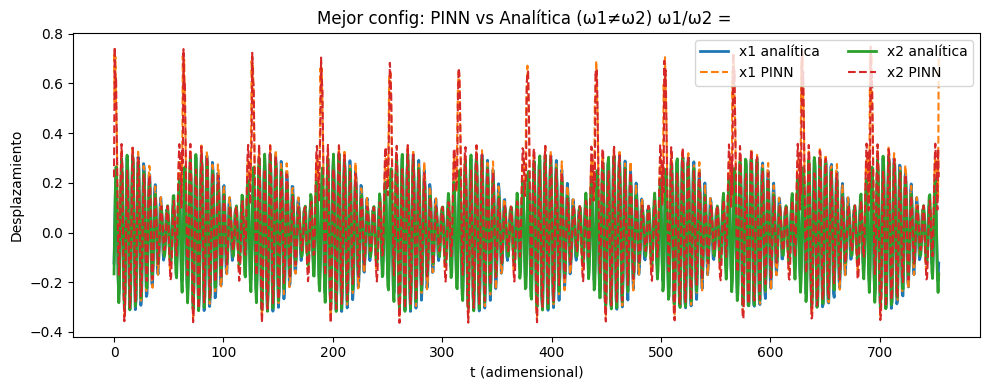

In [49]:
# 9 - GRÁFICAS: pérdidas y comparación PINN vs Analítica (ω1, ω2)
# Pérdidas
plt.figure(figsize=(8,4))
plt.plot(best_bundle["history"]["total"], label="Loss total")
plt.plot(best_bundle["history"]["phys"],  label="Loss física")
plt.plot(best_bundle["history"]["ic"],    label="Loss IC")
if best_bundle["meta"]["use_periodicity"]:
    plt.plot(best_bundle["history"]["per"], label="Loss periodicidad")
plt.yscale("log")
plt.xlabel("Época")
plt.ylabel("Loss (log)")
plt.title("Evolución de pérdidas (mejor configuración)")
plt.legend(); plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()

# Reconstrucción
t_grid_best = torch.linspace(t_ini, t_fin, N_EVAL, device=device).view(-1,1)
ff_vis = build_ff(best_bundle["hp"]["n_harmonics"], use_fourier=True)
n_in_best = ff_vis.out_features() if ff_vis is not None else 1
model_vis = build_model(n_in_best, width=best_bundle["arch"]["width"], depth=best_bundle["arch"]["depth"])
model_vis.load_state_dict(best_bundle["state"])

with torch.no_grad():
    x_hat_best = model_vis(encode_time(ff_vis, t_grid_best)).detach().cpu().numpy()

t_eval_best = t_grid_best.detach().cpu().numpy().squeeze()
w1, w2 = get_omegas()
x1r_best, x2r_best, _ = analytic_solution_twofreq(t_eval_best, P.zeta, P.kappa, P.A1, P.A2, w1, w2)

plt.figure(figsize=(10,4))
plt.plot(t_eval_best, x1r_best,        label="x1 analítica", linewidth=2)
plt.plot(t_eval_best, x_hat_best[:,0], "--",               label="x1 PINN")
plt.plot(t_eval_best, x2r_best,        label="x2 analítica", linewidth=2)
plt.plot(t_eval_best, x_hat_best[:,1], "--",               label="x2 PINN")
plt.xlabel("t (adimensional)")
plt.ylabel("Desplazamiento")
plt.title("Mejor config: PINN vs Analítica (ω1≠ω2) ω1/ω2 = ")
plt.legend(ncols=2)
plt.tight_layout()
plt.show()


In [50]:
# 11 - ANIMACIÓN PROGRESIVA (ensamblado manual con Pillow) — COHESIONADA
# --------------------------------------------------------------------------------------
import numpy as np
from PIL import Image
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

FRAME_STEP    = 1        # densidad de puntos revelados por frame
MAX_FRAMES    = None     # o un entero para limitar frames
DURATION_MS   = 48       # ms por frame en el GIF final

# Modelo final para inferencia (usar MISMO encoder y dimensiones que en train_run)
ff_final = build_ff(best_bundle["hp"]["n_harmonics"], use_fourier=True)
n_in_best = ff_final.out_features() if ff_final is not None else 1
model_final = build_model(n_in_best, width=best_bundle["arch"]["width"], depth=best_bundle["arch"]["depth"])
model_final.load_state_dict(best_bundle["state"])

# Predicción PINN final en toda la rejilla
t_grid_final = torch.linspace(t_ini, t_fin, N_EVAL, device=device).view(-1,1)
with torch.no_grad():
    x_hat_final_stream = model_final(encode_time(ff_final, t_grid_final)).detach().cpu().numpy()

# Analítica para ω1, ω2 actuales
t_eval_stream = t_grid_final.detach().cpu().numpy().ravel()
w1, w2 = get_omegas()
x1_real_stream, x2_real_stream, _ = analytic_solution_twofreq(
    t_eval_stream, P.zeta, P.kappa, P.A1, P.A2, w1, w2
)

# Submuestreo de índices para los frames (si procede)
indices = np.arange(len(t_eval_stream), dtype=int)
if FRAME_STEP > 1:
    indices = indices[::FRAME_STEP]
if (MAX_FRAMES is not None) and (len(indices) > MAX_FRAMES):
    factor = int(np.ceil(len(indices)/MAX_FRAMES))
    indices = indices[::max(1, factor)]
if len(indices) == 0 or indices[-1] != len(t_eval_stream)-1:
    indices = np.append(indices, len(t_eval_stream)-1)

# Lienzo y escalas
fig, ax = plt.subplots(figsize=(10,4))
canvas = FigureCanvas(fig)

ymin = min(x1_real_stream.min(), x2_real_stream.min(),
           x_hat_final_stream[:,0].min(), x_hat_final_stream[:,1].min())
ymax = max(x1_real_stream.max(), x2_real_stream.max(),
           x_hat_final_stream[:,0].max(), x_hat_final_stream[:,1].max())
pad = 0.05*(ymax - ymin + 1e-9)

ax.set_xlim(t_eval_stream[0], t_eval_stream[-1])
ax.set_ylim(ymin - pad, ymax + pad)
ax.set_xlabel("t (adimensional)")
ax.set_ylabel("Desplazamiento")
ax.set_title("Revelado temporal: PINN final vs Analítica (ω1 & ω2)")
ax.grid(True, alpha=0.3)

(line_real1_s,) = ax.plot([], [], label="x1 real", linewidth=2)
(line_real2_s,) = ax.plot([], [], label="x2 real", linewidth=2)
(line_hat1_s,)  = ax.plot([], [], "--", label="x1 PINN", alpha=0.9)
(line_hat2_s,)  = ax.plot([], [], "--", label="x2 PINN", alpha=0.9)
(pt_real1,)     = ax.plot([], [], "o", markersize=4)
(pt_real2,)     = ax.plot([], [], "o", markersize=4)
(pt_hat1,)      = ax.plot([], [], "o", markersize=4)
(pt_hat2,)      = ax.plot([], [], "o", markersize=4)
ax.legend(ncols=2)

# Generación de frames
frames = []
for k in indices:
    k = int(k)
    t_k = t_eval_stream[:k+1]

    line_real1_s.set_data(t_k, x1_real_stream[:k+1])
    line_real2_s.set_data(t_k, x2_real_stream[:k+1])
    line_hat1_s.set_data(t_k, x_hat_final_stream[:k+1, 0])
    line_hat2_s.set_data(t_k, x_hat_final_stream[:k+1, 1])

    pt_real1.set_data([t_eval_stream[k]], [x1_real_stream[k]])
    pt_real2.set_data([t_eval_stream[k]], [x2_real_stream[k]])
    pt_hat1.set_data([t_eval_stream[k]], [x_hat_final_stream[k,0]])
    pt_hat2.set_data([t_eval_stream[k]], [x_hat_final_stream[k,1]])

    canvas.draw()
    buf = np.asarray(canvas.buffer_rgba())
    frames.append(Image.fromarray(buf, mode="RGBA").convert("RGB"))

plt.close(fig)
if len(frames) == 0:
    raise RuntimeError("No se generaron frames (índices vacíos).")
elif len(frames) == 1:
    frames[0].save("anim_stream_progressive.gif")
else:
    frames[0].save(
        "anim_stream_progressive.gif",
        save_all=True,
        append_images=frames[1:],
        duration=DURATION_MS,
        
        loop=0,
        optimize=False
    )
print(f"GIF guardado: 'anim_stream_progressive.gif' | frames={len(frames)}, duration={DURATION_MS} ms")


/var/folders/q4/4c_1hfvj6973pnwzfzsxc9f80000gn/T/ipykernel_1730/405193633.py:84: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  frames.append(Image.fromarray(buf, mode="RGBA").convert("RGB"))


GIF guardado: 'anim_stream_progressive.gif' | frames=1200, duration=48 ms


In [ ]:
# 12 - APLICAR LA MEJOR CONFIGURACIÓN AL CONTEXTO GLOBAL
# ------------------------------------------------------------
USE_FOURIER = True
N_HARMONICS = best_bundle["hp"]["n_harmonics"]
ff = build_ff(OMEGAS, N_HARMONICS, USE_FOURIER)
n_in = 1 + 2*N_HARMONICS*len(OMEGAS)
model = build_model(n_in, width=best_bundle["arch"]["width"], depth=best_bundle["arch"]["depth"])
model.load_state_dict(best_bundle["state"])
print("Mejor arquitectura:", best_bundle["arch"])
print("Mejores hiperparámetros:", best_bundle["hp"])

Mejor arquitectura: {'name': 'MLP_w64_d3', 'width': 64, 'depth': 3}
Mejores hiperparámetros: {'name': 'HP_C_2', 'lr': 0.0007, 'epochs': 2500, 'n_harmonics': 4, 'use_periodicity': False, 'use_lbfgs': True, 'print_each': 500}


In [20]:
# SR1 - EXTRAER DATOS ANALÍTICOS DISCRETIZADOS PARA SR
# ----------------------------------------------------
# - Discretiza x1(t), x2(t) y sus derivadas v1(t), v2(t), a1(t), a2(t)
# - Construye residuales R1 y R2 (que equivalen a F1 y F2)
# - Exporta CSV para PySR
import numpy as np
import pandas as pd

# Utilidades analíticas (derivadas exactas de la solución estacionaria)
# Si X = Re(X) + i Im(X), entonces:
# x(t) = Re(X) cos(ωt) - Im(X) sin(ωt)
# v(t) = dx/dt = -ω[ Re(X) sin(ωt) + Im(X) cos(ωt) ]
# a(t) = d2x/dt2 = -ω^2 x(t)
def analytic_xva_arrays(t: np.ndarray, zeta: float, kappa: float, A1: float, A2: float, omega: float):
    X = analytic_amplitudes(zeta, kappa, A1, A2, omega)  # complejos [X1, X2]
    Xr, Xi = X.real, X.imag
    cosw, sinw = np.cos(omega*t), np.sin(omega*t)

    x1 = Xr[0]*cosw - Xi[0]*sinw
    x2 = Xr[1]*cosw - Xi[1]*sinw

    v1 = -omega*(Xr[0]*sinw + Xi[0]*cosw)
    v2 = -omega*(Xr[1]*sinw + Xi[1]*cosw)

    a1 = -omega**2 * x1
    a2 = -omega**2 * x2
    return x1, v1, a1, x2, v2, a2

# Rejilla temporal (usamos la misma que t_eval del notebook)
t_sr = np.linspace(t_ini, t_fin, N_EVAL)

# x, v, a analíticos en régimen estacionario
x1, v1, a1, x2, v2, a2 = analytic_xva_arrays(t_sr, P.zeta, P.kappa, P.A1, P.A2, P.omega)

# Residuales (lado izquierdo del sistema):  R1 = a1 + 2ζ v1 + (1+κ)x1 - κ x2,  R2 = a2 + 2ζ v2 + (1+κ)x2 - κ x1
R1 = a1 + 2.0*P.zeta*v1 + (1.0+P.kappa)*x1 - P.kappa*x2
R2 = a2 + 2.0*P.zeta*v2 + (1.0+P.kappa)*x2 - P.kappa*x1

# Verdaderas forzantes (para referencia)
F1_true = P.A1*np.cos(P.omega*t_sr)
F2_true = P.A2*np.sin(P.omega*t_sr)

# DataFrame
df_sr = pd.DataFrame({
    "t": t_sr,
    "x1": x1, "v1": v1, "a1": a1,
    "x2": x2, "v2": v2, "a2": a2,
    "R1": R1, "R2": R2,          # objetivos para SR: R1 ~ F1(t), R2 ~ F2(t)
    "F1_true": F1_true, "F2_true": F2_true
})

df_sr.to_csv("sr_dataset_analytic_coupled.csv", index=False)
print("Guardado -> sr_dataset_analytic_coupled.csv con columnas:", list(df_sr.columns))


NameError: name 'analytic_amplitudes' is not defined

In [18]:
# SR2 - REGRESIÓN SIMBÓLICA (PySR) PARA F1, F2 EN TRES ESCENARIOS
# ----------------------------------------------------------------
# Escenario 1: inferir F1 conociendo F2 (target = R1)
# Escenario 2: inferir F2 conociendo F1 (target = R2)
# Escenario 3: inferir F1 y F2 sin conocer ninguna (dos regresores, R1 y R2)
# Notas:
#  - Usamos X = [t]. PySR con sin/cos debería capturar la forma senoidal.
#  - Guardamos catálogos de ecuaciones en CSV.

import numpy as np
import pandas as pd

try:
    _df = df_sr.copy()
except NameError:
    _df = pd.read_csv("sr_dataset_analytic_coupled.csv")

X = _df[["t"]].to_numpy()
y1 = _df["R1"].to_numpy()  # ~ F1(t)
y2 = _df["R2"].to_numpy()  # ~ F2(t)
Y = _df[["R1", "R2"]].to_numpy()

# PySR
from pysr import PySRRegressor

base_kwargs = dict(
    niterations=60,                            # súbelo para mayor calidad (p.ej., 200-400)
    binary_operators=["+", "-", "*"],
    unary_operators=["sin", "cos", "exp", "inv(x) = 1/x"],
    extra_sympy_mappings={"inv": lambda x: 1/x},
    loss="L1DistLoss()",                       # robusto
    model_selection="score",
    complexity_of_operators={"sin":3, "cos":3, "exp":3, "inv(x) = 1/x":3},
    # procs=0,                                 # descomentar si necesitas mono-hilo
)

print("=== SR Caso 1: Inferir F1 conociendo F2 (objetivo R1) ===")
model_F1 = PySRRegressor(**base_kwargs)
model_F1.fit(X, y1)
expr_F1 = model_F1.sympy()
print("F1(t) ~", expr_F1)
eqF1 = model_F1.equations_
eqF1.to_csv("pysr_equations_F1.csv", index=False)

print("\n=== SR Caso 2: Inferir F2 conociendo F1 (objetivo R2) ===")
model_F2 = PySRRegressor(**base_kwargs)
model_F2.fit(X, y2)
expr_F2 = model_F2.sympy()
print("F2(t) ~", expr_F2)
eqF2 = model_F2.equations_
eqF2.to_csv("pysr_equations_F2.csv", index=False)

# === SR Caso 3: Inferir F1 y F2 a la vez (multi-output) — con priors trig y centrado ===
from pysr import PySRRegressor
import numpy as np
import pandas as pd
import re

# 1) Preprocesado: quitar media (evita que gane la constante)
m1, m2 = y1.mean(), y2.mean()
Yc = np.column_stack([y1 - m1, y2 - m2])

# 2) Regressor con prior trig y selección por pérdida
sr_kwargs = dict(
    niterations=300,                       # súbelo si quieres más calidad (p.ej., 600–1000)
    binary_operators=["+", "*"],          # sin '-', reduce polinomios arbitrarios
    unary_operators=["sin", "cos"],       # fuera exp, inv para acotar el espacio de búsqueda
    elementwise_loss="L2DistLoss()",      # en PySR nuevos usa elementwise_loss (antes: loss)
    model_selection="best",               # elige por pérdida mínima (no por score)
    complexity_of_operators={"+": 3, "*": 3, "sin": 1, "cos": 1},
    maxsize=16,                           # limita tamaño del árbol; aumenta si te quedas corto
    ncycles_per_iteration=200,            # más exploración por iteración
    # population_size=60,                 # puedes descomentar para poblaciones más grandes
    # procs=0,                            # fuerzar mono-hilo si lo necesitas
)

print("=== SR Caso 3 (multi-output, con centrado y prior trig) ===")
model_F12 = PySRRegressor(**sr_kwargs)
model_F12.fit(X, Yc, variable_names=["t"])

# 3) Extraer tablas de Hall of Fame por salida
assert isinstance(model_F12.equations_, list), "Se esperaba lista de DataFrames (multi-output)."
eqF1_df = model_F12.equations_[0].copy()
eqF2_df = model_F12.equations_[1].copy()

# 4) Post-selección: si hay sin/cos, quédate con la ecuación trig de MENOR pérdida;
#    si no hay, quédate con la global de menor pérdida.
def _pick_trig_best(eq_df: pd.DataFrame) -> pd.Series:
    # Columna estándar se llama 'equation' (texto) y 'loss'
    trig_mask = eq_df["equation"].str.contains(r"\b(sin|cos)\b", flags=re.IGNORECASE, regex=True)
    cand = eq_df[trig_mask]
    if len(cand) == 0:
        return eq_df.sort_values("loss", ascending=True).iloc[0]
    return cand.sort_values("loss", ascending=True).iloc[0]

bestF1_row = _pick_trig_best(eqF1_df)
bestF2_row = _pick_trig_best(eqF2_df)

print("\n=== Selección final por pérdida mínima entre trig (F1) ===")
print(bestF1_row[["complexity", "loss", "equation"]])
print("\n=== Selección final por pérdida mínima entre trig (F2) ===")
print(bestF2_row[["complexity", "loss", "equation"]])

# 5) Exportar catálogos y “best rows”
eqF1_df.to_csv("pysr_equations_F1.csv", index=False)
eqF2_df.to_csv("pysr_equations_F2.csv", index=False)
eqF1_df.assign(target="F1").pipe(lambda d1: pd.concat([d1, eqF2_df.assign(target="F2")])).to_csv(
    "pysr_equations_F12.csv", index=False
)
pd.DataFrame([bestF1_row]).to_csv("pysr_best_equation_F1.csv", index=False)
pd.DataFrame([bestF2_row]).to_csv("pysr_best_equation_F2.csv", index=False)
print("\nGuardados: pysr_equations_F1.csv / F2.csv / F12.csv y pysr_best_equation_F1.csv / F2.csv")

# 6) Predicción: el predictor interno usa su propia selección.
#    Para reinsertar el offset (media) al espacio original, sumamos [m1, m2].
Yhat_c = model_F12.predict(X)                    # (N,2) centrado
Yhat = Yhat_c + np.array([m1, m2])[None, :]      # de vuelta al original

_df["F1_hat_sym"] = Yhat[:, 0]
_df["F2_hat_sym"] = Yhat[:, 1]
_df.to_csv("sr_dataset_with_pysr_preds.csv", index=False)
print("Guardado -> sr_dataset_with_pysr_preds.csv (añade F1_hat_sym, F2_hat_sym)")

# 7) (Opcional) Imprimir las expresiones simbólicas “trig-best”
#    Nota: estas filas contienen la expresión en texto; si quieres SymPy:
from sympy import sympify, symbols
t = symbols("t")
expr_F1_sym = sympify(str(bestF1_row["equation"]))
expr_F2_sym = sympify(str(bestF2_row["equation"]))
print("\nF1(t) (post-selección trig) ~", expr_F1_sym)
print("F2(t) (post-selección trig) ~", expr_F2_sym)



=== SR Caso 1: Inferir F1 conociendo F2 (objetivo R1) ===


C:\Users\rmore\Desktop\OSCAR\CEIEC\PINNS_OsciladoresAcoplado-Forzados\.venv\Lib\site-packages\pysr\sr.py:1036: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
C:\Users\rmore\Desktop\OSCAR\CEIEC\PINNS_OsciladoresAcoplado-Forzados\.venv\Lib\site-packages\pysr\sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 1.440e+05
Progress: 801 / 1860 total iterations (43.065%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.369e-01  0.000e+00  y = 0.0011985
3           6.369e-01  2.980e-08  y = x₀ * 6.6797e-05
5           6.369e-01  1.431e-06  y = x₀ * (x₀ * 1.2938e-06)
6           1.355e-06  1.306e+01  y = cos(x₀ * -1.3)
───────────────────────────────────────────────────────────────────────────────────────────────────
════════════════════════════════════════════════════════════════════════════════════════════════════
Press 'q' and then <enter> to stop execution early.

Expressions evaluated per second: 1.480e+05
Progress: 1606 / 1860 total iterations (86.344%)
════════════════════════════════════════════════════════════════════════════════════════════════════

[ Info: Final population:
[ Info: Results saved to:
C:\Users\rmore\Desktop\OSCAR\CEIEC\PINNS_OsciladoresAcoplado-Forzados\.venv\Lib\site-packages\pysr\sr.py:1036: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
C:\Users\rmore\Desktop\OSCAR\CEIEC\PINNS_OsciladoresAcoplado-Forzados\.venv\Lib\site-packages\pysr\sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


  - outputs\20251006_185607_FWaxrw\hall_of_fame.csv


[ Info: Started!



Expressions evaluated per second: 1.180e+05
Progress: 712 / 1860 total iterations (38.280%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           3.817e-01  0.000e+00  y = 3.9067e-06
3           3.811e-01  7.463e-04  y = x₀ * -0.00076894
5           3.796e-01  1.994e-03  y = (x₀ * -0.0032573) - -0.094445
6           2.543e-01  4.003e-01  y = sin(x₀ * 1.3004)
8           2.197e-05  4.678e+00  y = sin(x₀ * 1.3) * 0.59997
───────────────────────────────────────────────────────────────────────────────────────────────────
════════════════════════════════════════════════════════════════════════════════════════════════════
Press 'q' and then <enter> to stop execution early.

Expressions evaluated per second: 1.490e+05
Progress: 1646 / 1860 total iterations (88.495%)
═══════════════════════════

[ Info: Final population:
[ Info: Results saved to:
C:\Users\rmore\Desktop\OSCAR\CEIEC\PINNS_OsciladoresAcoplado-Forzados\.venv\Lib\site-packages\pysr\sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 1.410e+05
Progress: 1385 / 18600 total iterations (7.446%)
════════════════════════════════════════════════════════════════════════════════════════════════════
Best equations for output 1
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           5.004e-01  0.000e+00  y₀ = -8.1671e-06
5           5.004e-01  1.490e-08  y₀ = t * 1.8845e-06
6           6.937e-07  1.349e+01  y₀ = cos(t * -1.3)
10          3.138e-11  2.501e+00  y₀ = cos(t * -1.3) + -0.00083044
───────────────────────────────────────────────────────────────────────────────────────────────────
════════════════════════════════════════════════════════════════════════════════════════════════════
Best equations for output 2
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           1.798e-01  0.000e+00  y₁ 

[ Info: Final populations:
[ Info: Output 1:
[ Info: Output 2:
[ Info: Results saved to:
C:\Users\rmore\AppData\Local\Temp\ipykernel_2416\2700754722.py:90: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  trig_mask = eq_df["equation"].str.contains(r"\b(sin|cos)\b", flags=re.IGNORECASE, regex=True)



=== Selección final por pérdida mínima entre trig (F1) ===
complexity                                     10
loss                                          0.0
equation      cos(t * -1.3000001) + -0.0008341216
Name: 3, dtype: object

=== Selección final por pérdida mínima entre trig (F2) ===
complexity                          10
loss                               0.0
equation      sin(t * 1.3) * 0.6000012
Name: 6, dtype: object

Guardados: pysr_equations_F1.csv / F2.csv / F12.csv y pysr_best_equation_F1.csv / F2.csv
Guardado -> sr_dataset_with_pysr_preds.csv (añade F1_hat_sym, F2_hat_sym)

F1(t) (post-selección trig) ~ cos(1.3000001*t) - 0.0008341216
F2(t) (post-selección trig) ~ 0.6000012*sin(1.3*t)
  - outputs\20251006_185632_w3hbo2\hall_of_fame_output2.csv


In [ ]:
# SR3 - MÉTRICAS Y GRÁFICAS (F1 y F2)
# ------------------------------------
import numpy as np
import matplotlib.pyplot as plt

# Predicciones simbólicas
pred_F1 = model_F1.predict(X).flatten()
pred_F2 = model_F2.predict(X).flatten()

# Objetivos
yF1 = y1.flatten()
yF2 = y2.flatten()

def report_and_plot(t, y_true, y_hat, name, df_ref=None, ref_col=None):
    corr = np.corrcoef(y_hat, y_true)[0, 1]
    mae  = np.mean(np.abs(y_hat - y_true))
    rmse = np.sqrt(np.mean((y_hat - y_true)**2))
    print(f"[{name}] Corr: {corr:.4f} | MAE: {mae:.3e} | RMSE: {rmse:.3e}")

    fig, ax = plt.subplots(1, 2, figsize=(11, 4))
    ax[0].scatter(y_true, y_hat, s=8, alpha=0.6)
    ax[0].set_xlabel(f"{name} objetivo"); ax[0].set_ylabel(f"{name} simbólico"); ax[0].grid(True)
    ax[0].set_title(f"{name}: Real vs. Predicho")

    ax[1].plot(t, y_true, lw=1, label=f"{name} objetivo")
    ax[1].plot(t, y_hat, lw=1, ls="--", label=f"{name} simbólico")
    if df_ref is not None and (ref_col in df_ref.columns):
        ax[1].plot(t, df_ref[ref_col].to_numpy(), lw=1, ls=":", label=f"{name} true")
    ax[1].set_xlabel("t"); ax[1].set_ylabel(name); ax[1].grid(True); ax[1].legend()
    ax[1].set_title(f"{name}: Serie temporal")
    plt.tight_layout(); plt.show()

# Reportes
report_and_plot(_df["t"].to_numpy(), yF1, pred_F1, "F1", df_ref=_df, ref_col="F1_true")
report_and_plot(_df["t"].to_numpy(), yF2, pred_F2, "F2", df_ref=_df, ref_col="F2_true")


F1(t) ≈ C1 cos(ω1 t) + S1 sin(ω1 t)
ω1_est = 1.298917 | A1_est = 1.000252 | φ1 = -0.031416 rad | (C1=0.999759, S1=-0.031419)
F2(t) ≈ C2 cos(ω2 t) + S2 sin(ω2 t)
ω2_est = 1.298917 | A2_est = 0.599629 | φ2 = 1.539395 rad | (C2=0.018826, S2=0.599333)

--- Comparación con parámetros verdaderos ---
ω true  = 1.300000
A1 true = 1.000000, A2 true = 0.600000
Nota: F1_true = A1 cos(ω t),  F2_true = A2 sin(ω t) => fases esperables: φ1≈0, φ2≈+π/2 aprox.


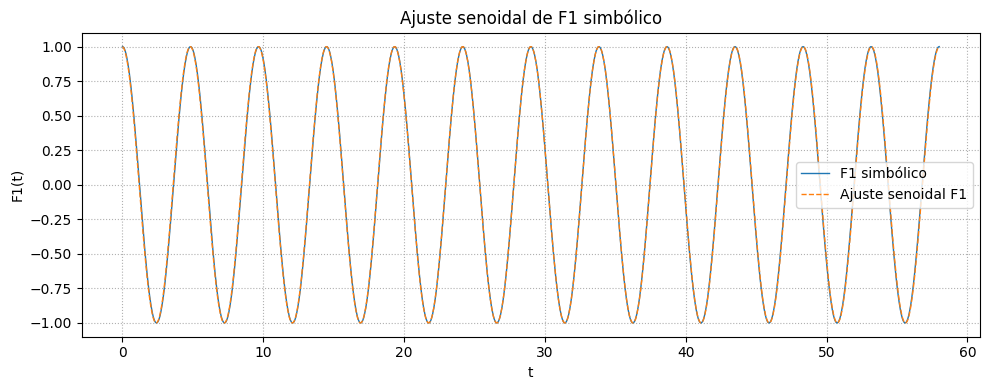

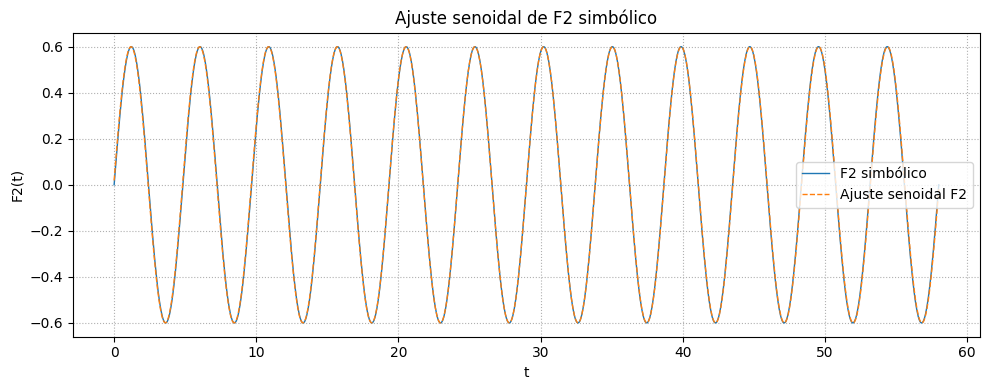

In [17]:
# SR4 - ESTIMAR ω, AMPLITUD Y FASE A PARTIR DE LAS SEÑALES SIMBÓLICAS
# --------------------------------------------------------------------
# Para F1_hat(t) y F2_hat(t), estimamos frecuencia dominante y parámetros
# F(t) ≈ C*cos(ω_est t) + S*sin(ω_est t)  ->  Amplitud= hypot(C,S), Fase = atan2(S,C)
from numpy.linalg import lstsq

t = _df["t"].to_numpy()
dt = t[1] - t[0]

def estimate_params(Fhat, t):
    freqs = np.fft.rfftfreq(len(t), d=dt)
    S = np.fft.rfft(Fhat)
    # ignoramos componente DC (índice 0)
    k = 1 + np.argmax(np.abs(S[1:]))
    w_est = 2*np.pi*freqs[k]
    Phi = np.column_stack([np.cos(w_est*t), np.sin(w_est*t)])
    coef, *_ = lstsq(Phi, Fhat, rcond=None)
    C, S_ = coef
    A_est  = float(np.hypot(C, S_))
    phi_est = float(np.arctan2(S_, C))
    return w_est, A_est, phi_est, (C, S_)

# F1
w1_est, A1_est, phi1_est, (C1, S1) = estimate_params(pred_F1, t)
print("F1(t) ≈ C1 cos(ω1 t) + S1 sin(ω1 t)")
print(f"ω1_est = {w1_est:.6f} | A1_est = {A1_est:.6f} | φ1 = {phi1_est:.6f} rad | (C1={C1:.6f}, S1={S1:.6f})")
# F2
w2_est, A2_est, phi2_est, (C2, S2) = estimate_params(pred_F2, t)
print("F2(t) ≈ C2 cos(ω2 t) + S2 sin(ω2 t)")
print(f"ω2_est = {w2_est:.6f} | A2_est = {A2_est:.6f} | φ2 = {phi2_est:.6f} rad | (C2={C2:.6f}, S2={S2:.6f})")

# Comparaciones con verdad (si procede)
print("\n--- Comparación con parámetros verdaderos ---")
print(f"ω true  = {P.omega:.6f}")
print(f"A1 true = {P.A1:.6f}, A2 true = {P.A2:.6f}")
print("Nota: F1_true = A1 cos(ω t),  F2_true = A2 sin(ω t) => fases esperables: φ1≈0, φ2≈+π/2 aprox.")

# Gráficas de proyección
F1_proj = C1*np.cos(w1_est*t) + S1*np.sin(w1_est*t)
F2_proj = C2*np.cos(w2_est*t) + S2*np.sin(w2_est*t)

import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.plot(t, pred_F1, lw=1, label="F1 simbólico")
plt.plot(t, F1_proj, '--', lw=1, label="Ajuste senoidal F1")
plt.xlabel("t"); plt.ylabel("F1(t)"); plt.title("Ajuste senoidal de F1 simbólico")
plt.grid(True, ls=':'); plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(10,4))
plt.plot(t, pred_F2, lw=1, label="F2 simbólico")
plt.plot(t, F2_proj, '--', lw=1, label="Ajuste senoidal F2")
plt.xlabel("t"); plt.ylabel("F2(t)"); plt.title("Ajuste senoidal de F2 simbólico")
plt.grid(True, ls=':'); plt.legend(); plt.tight_layout(); plt.show()
